In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from matplotlib import pyplot as plt

In [17]:
service = QiskitRuntimeService(instance="open-instance")

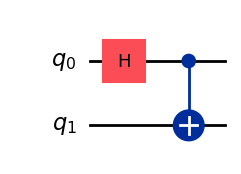

In [18]:
# Step 1: Map the problem to a quantum-native format
## Create a new circuit with two qubits
qc = QuantumCircuit(2)

## Add a Hadamard gate to qubit 0
qc.h(0)

## Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0,1)

# Return a draying of the circuit using matplotlib
qc.draw("mpl")

When creating quantum circuits, Qiskit provides two ways to return data:
    1. A probability distribution for a set of qubits you chose to measure
    2. An expectation value of an observable

In [19]:
# Set up six different observables
observables_labels = ["IZ", "IX", "ZI", "XI", 
"ZZ", # ZZ operator is shorthand for the tensor product of Z and Z
"XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

qiskit_runtime_service.__init__:WARNING:2025-11-18 17:34:23,552: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-18 17:34:23,809: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-18 17:34:25,352: Using instance: open-instance, plan: open


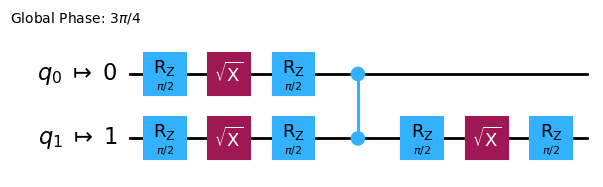

In [21]:
# Step 2: Optimize the circuits and operators
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

In [24]:
# Step 3: Execute using quantum primitives
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d4ea23h2bisc73a19p00


In [25]:
# Examine job results
# This is the result of the entire submission.
job_result = job.result()

# This is the result from the single pub with 6 observables. Contains information on all 6.
pub_result = job.result()[0]

When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the `fake_provider` with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit.

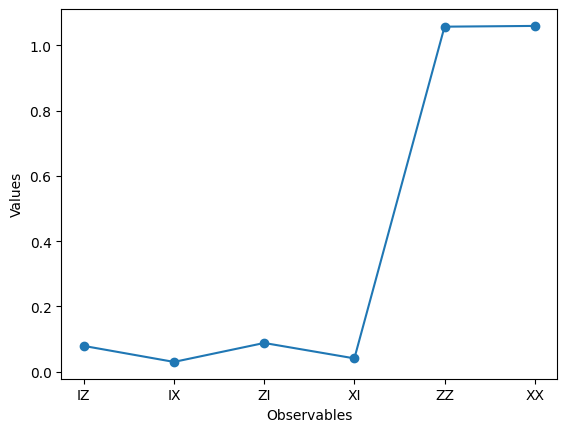

In [28]:
## Step 4: Analyze the results
values = pub_result.data.evs
errors = pub_result.data.stds

# Plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

In [ ]:
# Scale large number of qubits